In [1]:
import pandas as pd
import numpy as np
import hvplot.xarray

import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/DataAccess/Utilities')
import PreProcess_Utils as pputil

sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/Modelling/Utilities')
import Snow_Utils as snow_util

In [2]:
# from dask.distributed import LocalCluster

# cluster = LocalCluster(n_workers = 10, threads_per_worker = 10, memory_limit = 0) # Refined through testing, removing memory_limit is important
# client = cluster.get_client()
# client # Can open in other window by clicking 'Dashboard' link below

In [3]:
tile_stats = pd.read_csv(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\IMS (1 km)\Outputs\old\2024\tiles_IMS_SnowDynamics4HLS.csv", index_col = 0)
tile_stats # Note, not every tile (snow free removed)

,smin_avg,smax_avg,sstart_avg,send_avg,send_last,sstart_first
0,212.16667,36.6,3.000000,67.000000,90.0,335.0
1,219.50000,39.6,1.800000,73.600000,90.0,335.0
2,211.66667,36.6,9.800000,66.400000,90.0,335.0
3,196.33333,35.6,35.333332,69.333336,90.0,335.0
4,211.83333,39.4,5.200000,65.200000,90.0,335.0
...,...,...,...,...,...,...
3386,232.00000,39.2,-132.000000,232.000000,NaN,NaN
3387,227.83333,40.2,-136.166670,227.833330,NaN,NaN
3388,225.00000,37.6,-139.000000,225.000000,NaN,NaN
3389,230.33333,33.6,-133.666670,230.333330,NaN,NaN


In [4]:
tile_stats.iloc[904]

smin_avg        225.0
smax_avg         41.0
sstart_avg      -66.4
send_avg        152.4
send_last       156.0
sstart_first    279.0
Name: 904, dtype: float64

In [5]:
tile = 904 # From canadaFishnet_CanVec_60km
w_s = 2022 # Year that winter ends
w_e = 2023 # Year that winter starts
winterYear = str(w_s)[2:] + str(w_e)[2:] 

path = 'F:/HLS/Canada/Tiles60km/fmask/'

# Full Process to Winter Year Snow Dynamics

In [6]:
%%time
c_s = pputil.uploadNC(path + str(w_s) + '/fmask_' + str(tile) + '_' + str(w_s) + '.nc', 
                      form = 'dataarray',
                      chunks = {'time': 1, 'band': -1, 'x': -1, 'y': -1})
c_s

CPU times: total: 31.2 ms
Wall time: 1.61 s


<xarray.DataArray 'stackstac-627d2eace83517290dd72b196be3a68b' (time: 209,
                                                                band: 1,
                                                                y: 2001, x: 2001)> Size: 837MB
dask.array<open_dataset-stackstac-627d2eace83517290dd72b196be3a68b, shape=(209, 1, 2001, 2001), dtype=uint8, chunksize=(1, 1, 2001, 2001), chunktype=numpy.ndarray>
Coordinates:
  * band           (band) <U5 20B 'Fmask'
  * x              (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y              (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    constellation  (time) <U3 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 2kB 2022-01-13 ... 2022-12-01
Attributes:
    spec:        RasterSpec(epsg=3979, bounds=(648960, 595260, 708990, 655290...
    crs:         epsg:3979
    transform:   [ 3.0000e+01  0.0000e+00  6.4896e+05  0.0000e+00 -3.0000e+01...
    resolution:  30

In [7]:
%%time
c_e = pputil.uploadNC(path + str(w_e) + '/fmask_' + str(tile) + '_' + str(w_e) + '.nc', 
                      form = 'dataarray',
                      chunks = {'time': 1, 'band': -1, 'x': -1, 'y': -1})
c_e

CPU times: total: 15.6 ms
Wall time: 126 ms


<xarray.DataArray 'stackstac-3ff64834c7731e6e5f48b1539ab4eb78' (time: 198,
                                                                band: 1,
                                                                y: 2001, x: 2001)> Size: 793MB
dask.array<open_dataset-stackstac-3ff64834c7731e6e5f48b1539ab4eb78, shape=(198, 1, 2001, 2001), dtype=uint8, chunksize=(1, 1, 2001, 2001), chunktype=numpy.ndarray>
Coordinates:
  * band           (band) <U5 20B 'Fmask'
  * x              (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y              (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    constellation  (time) <U3 2kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 2kB 2023-01-13 ... 2023-12-01
Attributes:
    spec:        RasterSpec(epsg=3979, bounds=(648960, 595260, 708990, 655290...
    crs:         epsg:3979
    transform:   [ 3.0000e+01  0.0000e+00  6.4896e+05  0.0000e+00 -3.0000e+01...
    resolution:  30

In [8]:
%%time
snowCube = snow_util.annualFmask2SnowCube(c_s, c_e, yrs = 2, verbose = True) # yrs = 1, doy = doy
# Want to use 2 year cube to help get better results due to date gaps
snowCube

Initial Fmask time-steps: Start (n = 209), End (n = 198).
Made decision on same-day observations (L30vS30): Start (n = 167), End (n = 163).
Combined snow cube (n = 330).
Removed time-steps above 99% unclear pixels (n = 220).
Reclassifed (Snow = 1, Non-snow = 0, Unclear = NaN)
CPU times: total: 52.4 s
Wall time: 17.1 s


<xarray.DataArray 'stackstac-627d2eace83517290dd72b196be3a68b' (time: 220,
                                                                y: 2001, x: 2001)> Size: 4GB
dask.array<where, shape=(220, 2001, 2001), dtype=float32, chunksize=(1, 2001, 2001), chunktype=numpy.ndarray>
Coordinates:
    band         <U5 20B 'Fmask'
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
  * time         (time) datetime64[ns] 2kB 2022-01-20 2022-01-23 ... 2023-12-01
    spatial_ref  int64 8B 0

In [9]:
thresh = 2 # Originally 3 but in some situations leads to extra uncertainty


if np.isnan(tile_stats.loc[tile, 'send_last']) == True:
    implausible_snow = []
else: # Week buffer from latest recorded end date and earliest recorded start date
    implausible_snow = [int(tile_stats.loc[tile, 'send_last']) + 7, int(tile_stats.loc[tile, 'sstart_first']) - 7]

implausible_snow

[163, 272]

In [10]:
# %%time
# snowCube_c = snow_util.cleanSnowCube(snowCube, implausible_snow = implausible_snow, thresh = thresh)
# snowCube_c

In [11]:
# %%time
# snowCube_c = snow_util.dailySnowCube(snowCube_c, doy = int(tile_stats.loc[tile, 'smin_avg']), verbose = True)
# snowCube_c

In [12]:
# %%time
# snowDynamics = snow_util.dailySnowCube2SnowDynamics(snowCube_c, uncertainty = True, verbose = True) # Default settings
# snowDynamics

# Load Snow Cube

In [13]:
%%time
snowCube = pputil.loadXR(snowCube)
snowCube

[########################################] | 100% Completed | 13.21 ss
CPU times: total: 57.8 s
Wall time: 17.4 s


<xarray.DataArray 'stackstac-627d2eace83517290dd72b196be3a68b' (time: 220,
                                                                y: 2001, x: 2001)> Size: 4GB
array([[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1., nan, ...,  1.,  1.,  1.],
        [ 1.,  1., nan, ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [ 1.,  1., nan, ...,  1.,  1.,  1.],
        [ 1.,  1., nan, ...,  1.,  1.,  1.]],

       [[nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.]]], dtype=float32)
Coordinates:
    band         <U5 20B 'Fmask'
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
  * time         (time) datetime64[ns] 2kB 2022-01-20 2022-01-23 ... 2023-12-01
    spatial_ref  int64 8B 0

# Select good pixel(s)?
- x = 1208 (single period), 1208 (multiple periods)
- y = 1845 (single period), 1475 (multiple periods)

In [14]:
x = 1208 #np.random.randint(0, snowCube.shape[1])
print(x)
y = 1845 #np.random.randint(0, snowCube.shape[2])
print(y)

print(snowCube[:, x, y]['x'].values) #.rio.set_spatial_dims('x', 'y').rio.reproject('EPSG:4326')
print(snowCube[:, x, y]['y'].values)

(snowCube[:, x, y].rename('Snow Cube') # To plot with hvplot
                  .dropna(dim = 'time') # Prepare for daily resample
                  .resample(time = '1D').interpolate('linear').astype('float32') # Linear daily resample
                  # Reindex to fill 2 year time-series?
                  .hvplot(height = 600, width = 1500) * # Drop na and interpolate na to see full picture

(snowCube[:, x, y].hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points

1208
1845
704325.0
619035.0


:Overlay
   .Curve.I   :Curve   [time]   (Snow Cube)
   .Scatter.I :Scatter   [time]   (stackstac-627d2eace83517290dd72b196be3a68b)

# Get Results in Dataframe for Matplotlib

In [15]:
time_index = pd.date_range(start = '2022-01-01', end = '2023-12-31')
time_index

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', length=730, freq='D')

In [16]:
df = snowCube[:, x, y].rename('SnowCube_line').dropna(dim = 'time').resample(time = '1D').interpolate('linear').astype('float32').to_dataframe()
df = df.drop(['band', 'x', 'y', 'spatial_ref'], axis = 1)
df = df.reindex(time_index, method = 'nearest')
df

,SnowCube_line
2022-01-01,1.0
2022-01-02,1.0
2022-01-03,1.0
2022-01-04,1.0
2022-01-05,1.0
...,...
2023-12-27,1.0
2023-12-28,1.0
2023-12-29,1.0
2023-12-30,1.0


In [19]:
df1 = snowCube[:, x, y].to_dataframe()
df1 = df1.drop(['band', 'x', 'y', 'spatial_ref'], axis = 1)
#df1 = df1.rename(columns = {'stackstac-1b087a35d8fb3852cd9d76a26e8df9e9': 'SnowCube_pts'})
df1 = df1.rename(columns = {'stackstac-627d2eace83517290dd72b196be3a68b': 'SnowCube_pts'})

def unclear_pts(x):
    if np.isnan(x) == True:
        return -0.05

df1['unclear_pts'] = df1['SnowCube_pts'].apply(unclear_pts)

df1

,SnowCube_pts,unclear_pts
time,,
2022-01-20,1.0,NaN
2022-01-23,1.0,NaN
2022-01-25,NaN,-0.05
2022-01-28,1.0,NaN
2022-01-30,NaN,-0.05
...,...,...
2023-11-02,NaN,-0.05
2023-11-03,0.0,NaN
2023-11-19,1.0,NaN


In [20]:
df2 = pd.merge(df, df1, how = 'outer', left_index = True, right_index = True)
df2['unclear_line'] = -0.05
df2

,SnowCube_line,SnowCube_pts,unclear_pts,unclear_line
2022-01-01,1.0,NaN,NaN,-0.05
2022-01-02,1.0,NaN,NaN,-0.05
2022-01-03,1.0,NaN,NaN,-0.05
2022-01-04,1.0,NaN,NaN,-0.05
2022-01-05,1.0,NaN,NaN,-0.05
...,...,...,...,...
2023-12-27,1.0,NaN,NaN,-0.05
2023-12-28,1.0,NaN,NaN,-0.05
2023-12-29,1.0,NaN,NaN,-0.05
2023-12-30,1.0,NaN,NaN,-0.05


In [21]:
thresh = 2

snowCube_c = snow_util.cleanSnowCube(snowCube[:, x-5:x+5, y-5:y+5], implausible_snow = implausible_snow, thresh = thresh)
snowCube_c

Set all observations to non-snow between implausible snow dates (06-12 to 09-29).
Calculated cumulative sum that resets when non-snow is found.
Identified periods when 2+ consecutive snow observations occured (skipping NaN).
Created flipped snowCube to identify non-snow periods.
Calculated cumulative sum that resets when snow is found.
Identified periods when 2+ consecutive non-snow observations occured (skipping NaN).
Removed (NaN) snow and non-snow periods below 2 consecutive observations.


<xarray.DataArray (time: 220, y: 10, x: 10)> Size: 88kB
array([[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]], dtype=float32)
Coordinates:
    band         <U5 20B 'Fmask'
  * x            (x) float64 80B 7.042e+05 7.042e+05 ... 7.044e+05 7.044e+05
  * y            (y) float64 80B 6.192e+05 6.192e+05 ... 6.189e+05 6.189e+05
  * time         (time) datetime64[ns] 2kB 2022-01-20 2022-01-23 ... 2023-12-01
    spatial_ref  int64 8B 0

In [22]:
df = snowCube_c[:, 5, 5].rename('SnowCube_c_line').dropna(dim = 'time').resample(time = '1D').interpolate('linear').astype('float32').to_dataframe()
df = df.drop(['band', 'x', 'y', 'spatial_ref'], axis = 1)
df = df.reindex(time_index, method = 'nearest')
df

,SnowCube_c_line
2022-01-01,1.0
2022-01-02,1.0
2022-01-03,1.0
2022-01-04,1.0
2022-01-05,1.0
...,...
2023-12-27,1.0
2023-12-28,1.0
2023-12-29,1.0
2023-12-30,1.0


In [23]:
df1 = snowCube_c[:, 5, 5].rename('SnowCube_c_pts').to_dataframe()
df1 = df1.drop(['band', 'x', 'y', 'spatial_ref'], axis = 1)

def unclear_pts(x):
    if np.isnan(x) == True:
        return -0.05

df1['unclear_c_pts'] = df1['SnowCube_c_pts'].apply(unclear_pts)

df1

,SnowCube_c_pts,unclear_c_pts
time,,
2022-01-20,1.0,NaN
2022-01-23,1.0,NaN
2022-01-25,NaN,-0.05
2022-01-28,1.0,NaN
2022-01-30,NaN,-0.05
...,...,...
2023-11-02,NaN,-0.05
2023-11-03,0.0,NaN
2023-11-19,1.0,NaN


In [24]:
df2 = pd.merge(df2, df, how = 'outer', left_index = True, right_index = True)
df2 = pd.merge(df2, df1, how = 'outer', left_index = True, right_index = True)
df2

,SnowCube_line,SnowCube_pts,unclear_pts,unclear_line,SnowCube_c_line,SnowCube_c_pts,unclear_c_pts
2022-01-01,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
2022-01-02,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
2022-01-03,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
2022-01-04,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
2022-01-05,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
...,...,...,...,...,...,...,...
2023-12-27,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
2023-12-28,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
2023-12-29,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
2023-12-30,1.0,NaN,NaN,-0.05,1.0,NaN,NaN


In [25]:
snowCube_1D = snow_util.dailySnowCube(snowCube_c, doy = int(tile_stats.loc[tile, 'smin_avg']), verbose = True)
snowCube_1D

Filled in all NaNs in snowCube with linearly interpolated values in time.
Resampled to daily snowCube (2022-01-20 to 2023-12-01, n = 681) using linear interpolation.
Filtered to winter year (2022-08-14 to 2023-08-13, n = 365).
Reinidexing not required since daily snowCube already contains all possible dates.


<xarray.DataArray (time: 365, y: 10, x: 10)> Size: 146kB
dask.array<getitem, shape=(365, 10, 10), dtype=float32, chunksize=(365, 10, 10), chunktype=numpy.ndarray>
Coordinates:
    band         <U5 20B 'Fmask'
  * x            (x) float64 80B 7.042e+05 7.042e+05 ... 7.044e+05 7.044e+05
  * y            (y) float64 80B 6.192e+05 6.192e+05 ... 6.189e+05 6.189e+05
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 3kB 2022-08-14 2022-08-15 ... 2023-08-13

In [26]:
df = snowCube_1D[:, 5, 5].rename('SnowCube_1D').to_dataframe()
df = df.drop(['band', 'x', 'y', 'spatial_ref'], axis = 1)
df

,SnowCube_1D
time,
2022-08-14,0.0
2022-08-15,0.0
2022-08-16,0.0
2022-08-17,0.0
2022-08-18,0.0
...,...
2023-08-09,0.0
2023-08-10,0.0
2023-08-11,0.0


In [27]:
df2 = pd.merge(df2, df, how = 'outer', left_index = True, right_index = True)
df2

,SnowCube_line,SnowCube_pts,unclear_pts,unclear_line,SnowCube_c_line,SnowCube_c_pts,unclear_c_pts,SnowCube_1D
2022-01-01,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
2022-01-02,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
2022-01-03,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
2022-01-04,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
2022-01-05,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-27,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
2023-12-28,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
2023-12-29,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
2023-12-30,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN


In [28]:
#df2[df2['SnowCube_1D'].notnull()].iloc[-1]#.index

# Plot 1

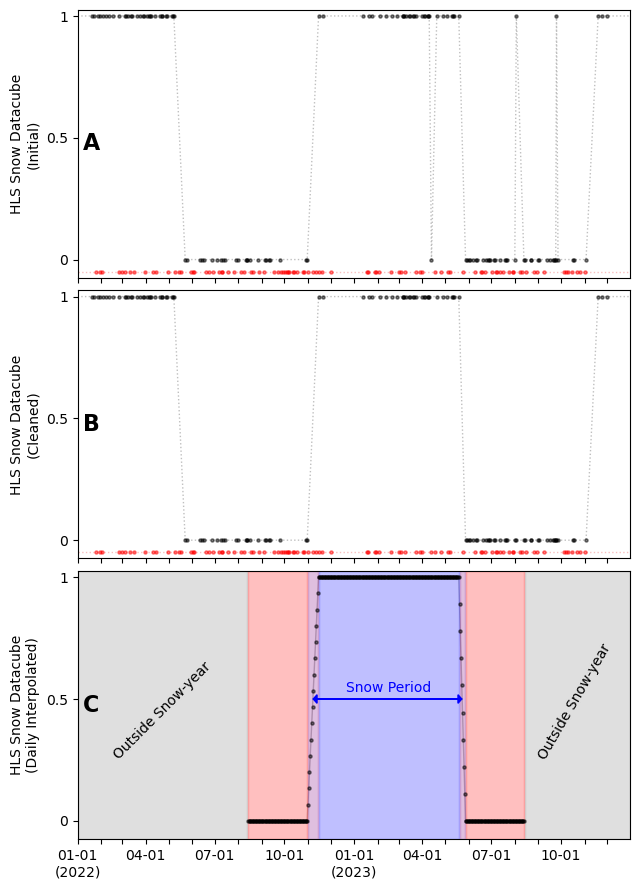

In [29]:
fig, axs = plt.subplots(3, 1, figsize = (6.5, 9), sharex = True, sharey = True)

size = 5
alpha = 0.5

# A
axs[0].text(0.01, 0.5, 'A', fontsize = 16, weight = 'bold', transform = axs[0].transAxes, va = 'center')

axs[0].scatter(df2.index, df2['SnowCube_pts'], c = 'black', s = size, zorder = 1, alpha = alpha)
axs[0].plot(df2.index, df2['SnowCube_line'], c = 'gray', linewidth = 1, linestyle = 'dotted', zorder = 0, alpha = alpha)

axs[0].scatter(df2.index, df2['unclear_pts'], c = 'red', s = size, zorder = 1, alpha = alpha)
axs[0].plot(df2.index, df2['unclear_line'], c = 'lightcoral', linewidth = 1, linestyle = 'dotted', zorder = 0, alpha = alpha)

axs[0].set_ylabel('HLS Snow Datacube\n(Initial)')

# B
axs[1].text(0.01, 0.5, 'B', fontsize = 16, weight = 'bold', transform = axs[1].transAxes, va = 'center')

axs[1].scatter(df2.index, df2['SnowCube_c_pts'], c = 'black', s = size, zorder = 1, alpha = alpha)
axs[1].plot(df2.index, df2['SnowCube_c_line'], c = 'gray', linewidth = 1, linestyle = 'dotted', zorder = 0, alpha = alpha)

axs[1].scatter(df2.index, df2['unclear_c_pts'], c = 'red', s = size, zorder = 1, alpha = alpha)
axs[1].plot(df2.index, df2['unclear_line'], c = 'lightcoral', linewidth = 1, linestyle = 'dotted', zorder = 0, alpha = alpha)

axs[1].set_ylabel('HLS Snow Datacube\n(Cleaned)')

# C
axs[2].text(0.01, 0.5, 'C', fontsize = 16, weight = 'bold', transform = axs[2].transAxes, va = 'center')
axs[2].text(0.06, 0.3, 'Outside Snow-year', fontsize = 10,  transform = axs[2].transAxes, rotation = 45)
axs[2].text(0.83, 0.3, 'Outside Snow-year', fontsize = 10,  transform = axs[2].transAxes, rotation = 60)

axs[2].fill_between(df2.index, -0.075, 1.025, where = df2['SnowCube_1D'].isnull(), color = 'gray', alpha = 0.25)
axs[2].fill_between(df2.index, -0.075, 1.025, where = df2['SnowCube_1D'] == 1, color = 'blue', alpha = 0.25)
axs[2].fill_between(df2.index, -0.075, 1.025, where = (df2['SnowCube_1D'] > 0) & (df2['SnowCube_1D'] < 1), color = 'purple', alpha = 0.25)
axs[2].fill_between(df2.index, -0.075, 1.025, where = df2['SnowCube_1D'] == 0, color = 'red', alpha = 0.25)
# axs[2].axvline(df2[df2['SnowCube_1D'].notnull()].iloc[0:1].index)
# axs[2].axvline(df2[df2['SnowCube_1D'].notnull()].iloc[-1:].index)

axs[2].scatter(df2.index, df2['SnowCube_1D'], c = 'black', s = size, zorder = 1, alpha = alpha)
axs[2].plot(df2.index, df2['SnowCube_1D'], c = 'gray', linewidth = 1, linestyle = 'solid', zorder = 0, alpha = alpha)

axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2022-11-08')), dy = 0, dx = 196, 
             length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2023-05-23')), dy = 0, dx = -196, 
             length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
axs[2].text(0.485, 0.55, 'Snow Period', fontsize = 10,  transform = axs[2].transAxes, color = 'blue')

# axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2022-11-11')), dy = 0, dx = 164, 
#              length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
# axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2023-04-24')), dy = 0, dx = -164, 
#              length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
# axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2023-05-07')), dy = 0, dx = 16, 
#              length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
# axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2023-05-23')), dy = 0, dx = -16, 
#              length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
# axs[2].text(0.47, 0.55, 'Snow Periods', fontsize = 10,  transform = axs[2].transAxes, color = 'blue')

axs[2].set_xlim([pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31')])
axs[2].set_xticks([pd.Timestamp('2022-01-01'), pd.Timestamp('2022-02-01'), pd.Timestamp('2022-03-01'), pd.Timestamp('2022-04-01'),
                   pd.Timestamp('2022-05-01'), pd.Timestamp('2022-06-01'), pd.Timestamp('2022-07-01'), pd.Timestamp('2022-08-01'),
                   pd.Timestamp('2022-09-01'), pd.Timestamp('2022-10-01'), pd.Timestamp('2022-11-01'), pd.Timestamp('2022-12-01'),
                   pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-01'), pd.Timestamp('2023-03-01'), pd.Timestamp('2023-04-01'),
                   pd.Timestamp('2023-05-01'), pd.Timestamp('2023-06-01'), pd.Timestamp('2023-07-01'), pd.Timestamp('2023-08-01'),
                   pd.Timestamp('2023-09-01'), pd.Timestamp('2023-10-01'), pd.Timestamp('2023-11-01'), pd.Timestamp('2023-12-01')],
                  ['01-01\n(2022)', '', '', '04-01', '', '', '07-01', '', '', '10-01', '', '',
                   '01-01\n(2023)', '', '', '04-01', '', '', '07-01', '', '', '10-01', '', ''])

axs[2].set_ylim(-0.075, 1.025)
axs[2].set_yticks([0, 0.5, 1], ['0', '0.5', '1'])
axs[2].set_ylabel('HLS Snow Datacube\n(Daily Interpolated)')

plt.tight_layout(h_pad = 0.5, w_pad = 0)

plt.show()

#fig.get_figure().savefig('Figure A10.tif', dpi = 600, bbox_inches = 'tight', pil_kwargs = {'compression': 'tiff_lzw'})

In [30]:
# import datetime
# mpl.dates.date2num(pd.Timestamp('2022-05-01'))

In [31]:
# binary = df2['SnowCube_1D'].where(df2['SnowCube_1D'].notnull(), 1)
# binary

In [32]:
# df2['SnowCube_1D'].values > 0.5
# df2['SnowCube_1D'].isnull()

In [33]:
# df2['SnowCube_1D'][280:320]

In [34]:
#mpl.dates.date2num(pd.Timestamp('2023-05-23')) - mpl.dates.date2num(pd.Timestamp('2022-11-08'))

# Snow Dynamic Images

In [35]:
# print(tile)
# print(winterYear)

In [36]:
snowDynamics = pputil.uploadNC(r"F:\HLS\Canada\Tiles60km\snowDynamics_fmask_v1\winterYear\904\HLS_Fmask_snowDynamics_winterYear2223_904.nc", form = 'dataset')
snowDynamics

<xarray.Dataset> Size: 96MB
Dimensions:        (winterYear: 1, x: 2001, y: 2001)
Coordinates:
  * winterYear     (winterYear) <U9 36B '2022-2023'
  * x              (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y              (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref    int64 8B ...
Data variables:
    snow_start     (winterYear, y, x) float32 16MB ...
    snow_end       (winterYear, y, x) float32 16MB ...
    snow_length    (winterYear, y, x) uint16 8MB ...
    snow_periods   (winterYear, y, x) uint8 4MB ...
    snow_status    (winterYear, y, x) uint8 4MB ...
    snow_start_u   (winterYear, y, x) float32 16MB ...
    snow_end_u     (winterYear, y, x) float32 16MB ...
    snow_length_u  (winterYear, y, x) float32 16MB ...

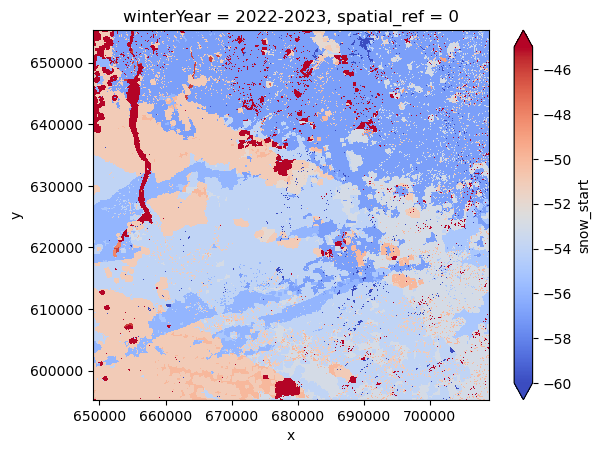

In [37]:
start = snowDynamics['snow_start'].compute()
start.plot(vmin = -60, vmax = -45, cmap = 'coolwarm')

In [38]:
# start.plot.hist()
# start.mean()

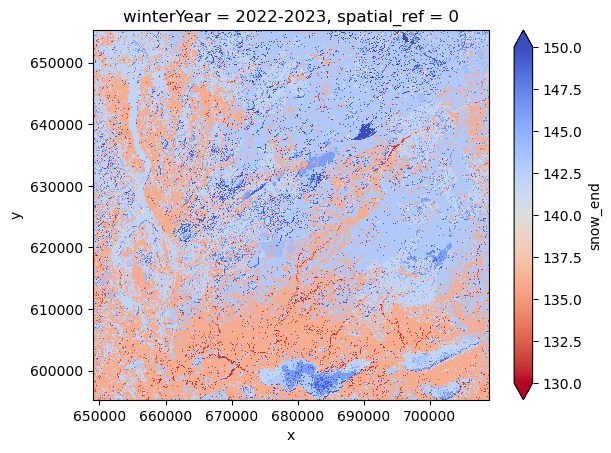

In [39]:
end = snowDynamics['snow_end'].compute()
end.plot(vmin = 130, vmax = 150, cmap = 'coolwarm_r')

In [40]:
# end.plot.hist()
# end.mean()

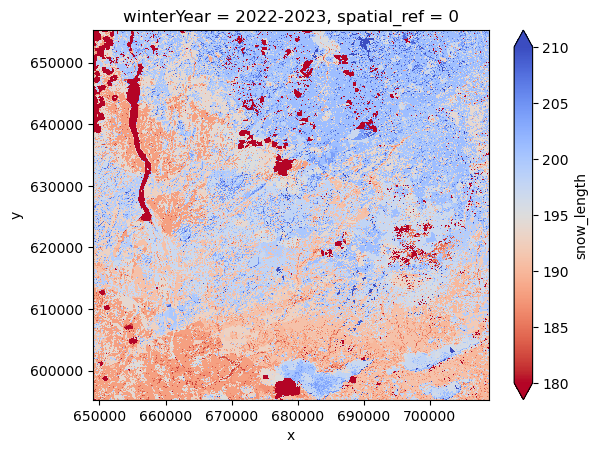

In [41]:
length = snowDynamics['snow_length'].compute()
length.plot(vmin = 180, vmax = 210, cmap = 'coolwarm_r')

In [42]:
# length.plot.hist()
# length.mean()

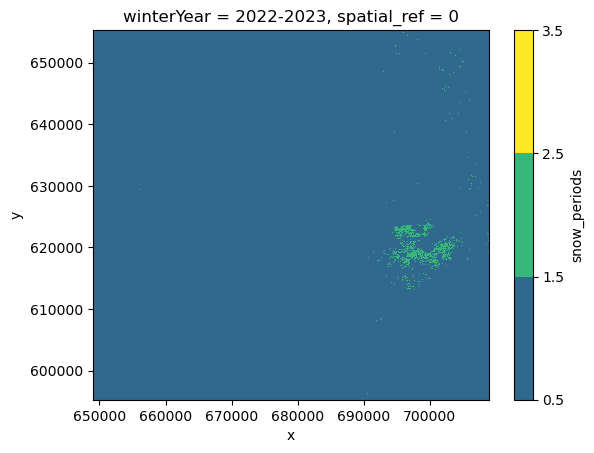

In [43]:
periods = snowDynamics['snow_periods'].compute()

colors = ['#31688E', '#35B879', '#FEE825']
scale = [0.5, 1.5, 2.5, 3.5]

cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(scale, len(colors))  

periods.plot(cmap = cmap, norm = norm)

In [44]:
# periods.plot.hist()
# periods.max()

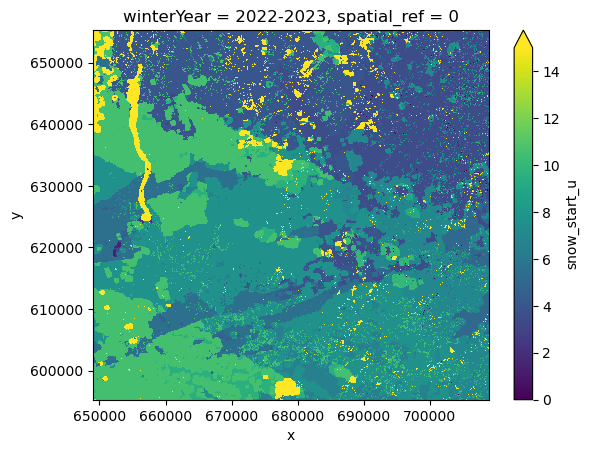

In [45]:
start_u = snowDynamics['snow_start_u'].compute()
start_u.plot(vmin = 0, vmax = 15)

In [46]:
# start_u.plot.hist()
# start_u.mean()

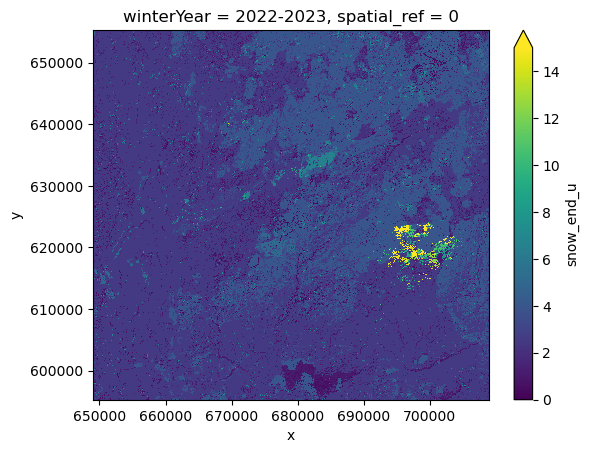

In [47]:
end_u = snowDynamics['snow_end_u'].compute()
end_u.plot(vmin = 0, vmax = 15)

In [48]:
# end_u.plot.hist()
# end_u.mean()

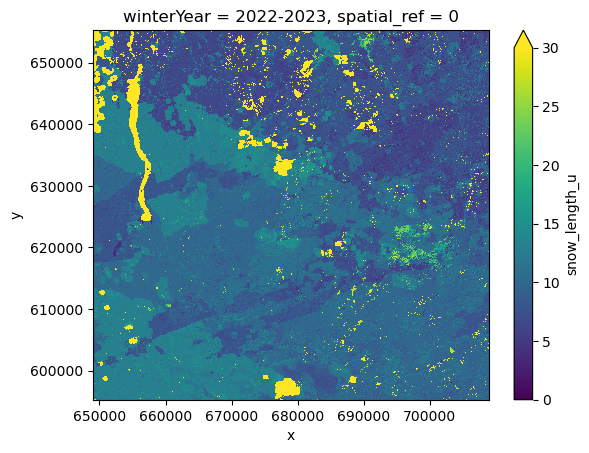

In [49]:
length_u = snowDynamics['snow_length_u'].compute()
length_u.plot(vmin = 0, vmax = 30)

In [50]:
# length_u.plot.hist()
# length_u.mean()

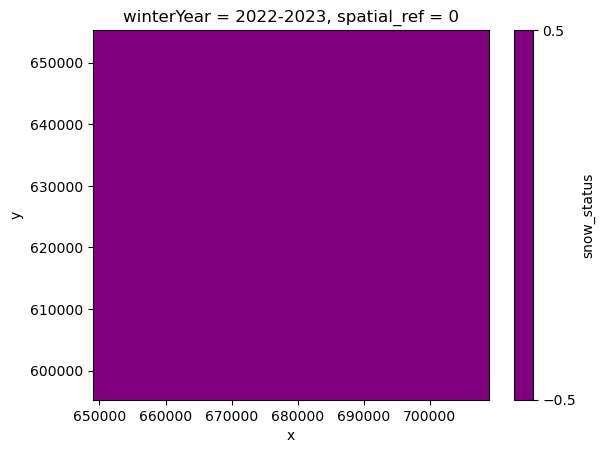

In [51]:
status = snowDynamics['snow_status'].compute()

colors = ['purple']
scale = [-0.5, 0.5]

cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(scale, len(colors))  

status.plot(cmap = cmap, norm = norm)

# Plot 2

In [52]:
# axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2022-11-08')), dy = 0, dx = 196, 
#              length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
# axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2023-05-23')), dy = 0, dx = -196, 
#              length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
# axs[2].text(0.485, 0.55, 'Snow Period', fontsize = 10,  transform = axs[2].transAxes, color = 'blue')

In [53]:
#cax params
loc = 'bottom'
pad = 0.03
shrink = 0.75

# arr params
facecolor = 'black'
lw = 1.5
fontsize = 8
head_length = 2
head_width = 0.02

In [54]:
#df2['SnowCube_1D'][500:550]

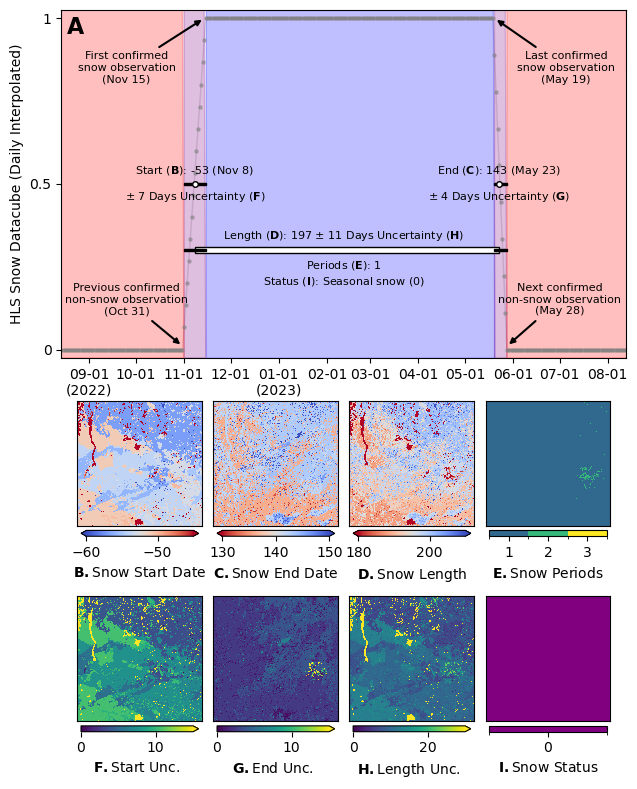

In [56]:
fig = plt.figure(figsize = (6.5, 8))

# Pixel plot with all metrics
axA = plt.subplot2grid((4, 4), (0, 0), colspan = 4, rowspan = 2)
axA.text(0.01, 0.95, 'A', fontsize = 16, weight = 'bold', transform = axA.transAxes, va = 'center')

axA.fill_between(df2.index, -0.025, 1.025, where = df2['SnowCube_1D'] == 1, color = 'blue', alpha = 0.25, interpolate = True)
axA.fill_between(df2.index, -0.025, 1.025, where = (df2['SnowCube_1D'] > 0) & (df2['SnowCube_1D'] < 1), color = 'purple', alpha = 0.25, 
                 interpolate = True)
axA.fill_between(df2.index, -0.025, 1.025, where = df2['SnowCube_1D'] == 0, color = 'red', alpha = 0.25, interpolate = True)

axA.scatter(df2.index, df2['SnowCube_1D'], c = 'gray', s = 5, zorder = 1, alpha = 0.5)
axA.plot(df2.index, df2['SnowCube_1D'], c = 'gray', linewidth = 1, linestyle = 'solid', zorder = 0, alpha = 0.25)

axA.annotate('First confirmed\nsnow observation\n(Nov 15)', xy = (mpl.dates.date2num(pd.Timestamp('2022-11-14')), 1), 
             xytext = (mpl.dates.date2num(pd.Timestamp('2022-09-25')), 0.85), fontsize = fontsize, ha = 'center', va = 'center',
             arrowprops = dict(arrowstyle = '-|>', facecolor = facecolor, lw = 1.5))
axA.annotate('Previous confirmed\nnon-snow observation\n(Oct 31)', xy = (mpl.dates.date2num(pd.Timestamp('2022-10-31')), 0.01), 
             xytext = (mpl.dates.date2num(pd.Timestamp('2022-09-25')), 0.15), fontsize = fontsize, ha = 'center', va = 'center',
             arrowprops = dict(arrowstyle = '-|>', facecolor = facecolor, lw = 1.5))
axA.annotate('Last confirmed\nsnow observation\n(May 19)', xy = (mpl.dates.date2num(pd.Timestamp('2023-05-20')), 1), 
             xytext = (mpl.dates.date2num(pd.Timestamp('2023-07-05')), 0.85), fontsize = fontsize, ha = 'center', va = 'center',
             arrowprops = dict(arrowstyle = '-|>', facecolor = facecolor, lw = 1.5))
axA.annotate('Next confirmed\nnon-snow observation\n(May 28)', xy = (mpl.dates.date2num(pd.Timestamp('2023-05-28')), 0.01), 
             xytext = (mpl.dates.date2num(pd.Timestamp('2023-07-01')), 0.15), fontsize = fontsize, ha = 'center', va = 'center',
             arrowprops = dict(arrowstyle = '-|>', facecolor = facecolor, lw = 1.5))

axA.arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2022-11-01')), dy = 0, dx = 14, 
          length_includes_head = False, head_width = 0, head_length = 0, color = facecolor, width = 0.005) # 10-31, 15
# axA.arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2022-11-15')), dy = 0, dx = -15, 
#           length_includes_head = False, head_width = 0, head_length = 0, color = facecolor)
axA.plot(pd.Timestamp('2022-11-08'), 0.5, marker = 'o', ms = 4, mec = 'black', mfc = 'white')
axA.text(mpl.dates.date2num(pd.Timestamp('2022-11-08')), 0.54, 'Start ($\\bf{B}$): -53 (Nov 8)', fontsize = fontsize, ha = 'center', va = 'center')
axA.text(mpl.dates.date2num(pd.Timestamp('2022-11-08')), 0.46, '± 7 Days Uncertainty ($\\bf{F}$)', fontsize = fontsize, ha = 'center', va = 'center')

axA.arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2023-05-20')), dy = 0, dx = 8, 
          length_includes_head = False, head_width = 0, head_length = 0, color = facecolor, width = 0.005) # 5-20, 8
# axA.arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2023-05-28')), dy = 0, dx = -8, 
#           length_includes_head = True, head_width = head_width, head_length = head_length, color = facecolor)
axA.plot(pd.Timestamp('2023-05-23'), 0.5, marker = 'o', ms = 4, mec = 'black', mfc = 'white')
axA.text(mpl.dates.date2num(pd.Timestamp('2023-05-23')), 0.54, 'End ($\\bf{C}$): 143 (May 23)', fontsize = fontsize,  ha = 'center', va = 'center')
axA.text(mpl.dates.date2num(pd.Timestamp('2023-05-23')), 0.46, '± 4 Days Uncertainty ($\\bf{G}$)', fontsize = fontsize, ha = 'center', va = 'center')

axA.arrow(y = 0.3, x = mpl.dates.date2num(pd.Timestamp('2022-11-08')), dy = 0, dx = 196, 
          length_includes_head = False, head_width = 0, head_length = 0, facecolor = 'white', edgecolor = 'black', width = 0.02)
axA.arrow(y = 0.3, x = mpl.dates.date2num(pd.Timestamp('2022-11-01')), dy = 0, dx = 14, 
          length_includes_head = False, head_width = 0, head_length = 0, color = facecolor, width = 0.005) # 11-01, 14
# axA.arrow(y = 0.3, x = mpl.dates.date2num(pd.Timestamp('2022-11-15')), dy = 0, dx = -15, 
#           length_includes_head = True, head_width = head_width, head_length = head_length, color = facecolor)
axA.arrow(y = 0.3, x = mpl.dates.date2num(pd.Timestamp('2023-05-20')), dy = 0, dx = 8, 
          length_includes_head = False, head_width = 0, head_length = 0, color = facecolor, width = 0.005) # 5-20, 8
# axA.arrow(y = 0.3, x = mpl.dates.date2num(pd.Timestamp('2023-05-28')), dy = 0, dx = -8, 
#           length_includes_head = True, head_width = head_width, head_length = head_length, color = facecolor)
axA.text(0.5, 0.35, 'Length ($\\bf{D}$): 197 ± 11 Days Uncertainty ($\\bf{H}$)', fontsize = fontsize,  transform = axA.transAxes,
         ha = 'center', va = 'center')

axA.text(0.5, 0.265, 'Periods ($\\bf{E}$): 1', fontsize = fontsize,  transform = axA.transAxes, ha = 'center', va = 'center')

axA.text(0.5, 0.22, 'Status ($\\bf{I}$): Seasonal snow (0)', fontsize = fontsize,  transform = axA.transAxes, 
         ha = 'center', va = 'center')

axA.set_xlim([df2[df2['SnowCube_1D'].notnull()].index[0], df2[df2['SnowCube_1D'].notnull()].index[-1]])
axA.set_ylim(-0.025, 1.025)

axA.set_xticks([pd.Timestamp('2022-09-01'), pd.Timestamp('2022-10-01'), pd.Timestamp('2022-11-01'), pd.Timestamp('2022-12-01'),
                pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-01'), pd.Timestamp('2023-03-01'), pd.Timestamp('2023-04-01'),
                pd.Timestamp('2023-05-01'), pd.Timestamp('2023-06-01'), pd.Timestamp('2023-07-01'), pd.Timestamp('2023-08-01')],
                ['09-01\n(2022)', '10-01', '11-01', '12-01', '01-01\n(2023)', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01'])
axA.set_yticks([0, 0.5, 1], ['0', '0.5', '1'])

axA.set_ylabel('HLS Snow Datacube (Daily Interpolated)')

# Tile plot (start)
axB = plt.subplot2grid((4, 4), (2, 0))

start.plot(ax = axB, add_labels = False, xticks = [], yticks = [], vmin = -60, vmax = -45, cmap = 'coolwarm', 
           cbar_kwargs = {'location': loc, 'pad': pad, 'shrink': shrink, 'label': '$\\bf{B.}$Snow Start Date'})

axB.set_box_aspect(1)

# Tile plot (end)
axC = plt.subplot2grid((4, 4), (2, 1))

end.plot(ax = axC, add_labels = False, xticks = [], yticks = [], vmin = 130, vmax = 150, cmap = 'coolwarm_r', 
         cbar_kwargs = {'location': loc, 'pad': pad, 'shrink': shrink, 'label': '$\\bf{C.}$Snow End Date'})

axC.set_box_aspect(1)

# Tile plot (length)
axD = plt.subplot2grid((4, 4), (2, 2))

length.plot(ax = axD, add_labels = False, xticks = [], yticks = [], vmin = 180, vmax = 210, cmap = 'coolwarm_r', 
            cbar_kwargs = {'location': loc, 'pad': pad, 'shrink': shrink, 'label': '$\\bf{D.}$Snow Length'})

axD.set_box_aspect(1)

# Tile plot (periods)
axE = plt.subplot2grid((4, 4), (2, 3))

colors = ['#31688E', '#35B879', '#FEE825']
scale = [0.5, 1.5, 2.5, 3.5]
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(scale, len(colors))  

periods.plot(ax = axE, add_labels = False, xticks = [], yticks = [], cmap = cmap, norm = norm,  
             cbar_kwargs = {'location': loc, 'pad': pad, 'shrink': shrink, 'label': '$\\bf{E.}$Snow Periods', 'ticks': [1, 2, 3]})

axE.set_box_aspect(1)

# Tile plot (start uncertainty)
axF = plt.subplot2grid((4, 4), (3, 0))

start_u.plot(ax = axF, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 15, 
             cbar_kwargs = {'location': loc, 'pad': pad, 'shrink': shrink, 'label': '$\\bf{F.}$Start Unc.'})

axF.set_box_aspect(1)

# Tile plot (end uncertainty)
axG = plt.subplot2grid((4, 4), (3, 1))

end_u.plot(ax = axG, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 15, 
           cbar_kwargs = {'location': loc, 'pad': pad, 'shrink': shrink, 'label': '$\\bf{G.}$End Unc.'})

axG.set_box_aspect(1)

# Tile plot (length uncertainty)
axH = plt.subplot2grid((4, 4), (3, 2))

length_u.plot(ax = axH, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 30, 
              cbar_kwargs = {'location': loc, 'pad': pad, 'shrink': shrink, 'label': '$\\bf{H.}$Length Unc.'})

axH.set_box_aspect(1)

# Tile plot (status)
axI = plt.subplot2grid((4, 4), (3, 3))

colors = ['purple']
scale = [-0.5, 0.5]
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(scale, len(colors))  

status.plot(ax = axI, add_labels = False, xticks = [], yticks = [], cmap = cmap, norm = norm, 
            cbar_kwargs = {'location': loc, 'pad': pad, 'shrink': shrink, 'label': '$\\bf{I.}$Snow Status','ticks': [0]})

axI.set_box_aspect(1)

plt.tight_layout(h_pad = 0.25, w_pad = -1.5)

fig.get_figure().savefig('Figure 6.tif', dpi = 600, bbox_inches = 'tight', pil_kwargs = {'compression': 'tiff_lzw'})